In [1]:
%matplotlib inline
import numpy
from astropy.io import fits
import h5py
from sys import  path
path.append("/home/hkli/work/mylib/")
import tool_box
from plot_tool import Image_Plot
import matplotlib.pyplot as plt
import os
from Fourier_Quad import Fourier_Quad
from astropy.coordinates import SkyCoord
from astropy import units as astro_unit

In [3]:
fq = Fourier_Quad(12,1)

deg2arcmin = 60
arcmin2rad = 1./60/180*numpy.pi

h5f = h5py.File("/mnt/ddnfs/data_users/hkli/CFHT/gg_lensing/data/foreground/CFHT_cluster/w_1_sub.hdf5","r")
fore_dist = h5f["/DISTANCE"].value
fore_cos_dec = h5f["/COS_DEC"].value
fore_n200 = h5f["/N200"].value
fore_ra = h5f["/RA"].value*deg2arcmin
fore_dec = h5f["/DEC"].value*deg2arcmin
fore_z = h5f["/Z"].value
h5f.close()

In [6]:
igal = 2

area_id = 1

delta_z = 0.1
sgima_coeff = 388.283351
names = ["Z", "RA", "DEC", "G1", "G2", "N", "U", "V", "COS_DEC", "DISTANCE"]

# background data
h5f = h5py.File("/mnt/ddnfs/data_users/hkli/CFHT/gg_lensing/data/foreground/CFHT_cluster/w_1_sub.hdf5","r")

redshift_all = h5f["/%d/Z" %igal].value
data = numpy.zeros((redshift_all.shape[0], len(names)))
data[:, 0] = redshift_all
for i in range(1, len(names)):
    data_arr = h5f["/%d/%s" % (igal, names[i])].value
    if len(data_arr.shape) > 1:
        data[:, i] = data_arr[:, 0]
    else:
        data[:, i] = data_arr
# the x-coord is opposite to RA
data[:, names.index("G2")] = - data[:, names.index("G2")]
h5f.close()

idx_z = data[:, names.index("Z")] >= fore_z[igal] + delta_z

# sub-area
redshift = data[:, names.index("Z")][idx_z]
dist = data[:,names.index("DISTANCE")][idx_z]

sigma_crit = sgima_coeff*dist/(dist - fore_dist[igal])/fore_dist[igal]*(1+fore_z[igal])

ra = data[:, names.index("RA")][idx_z]*deg2arcmin
dec = data[:, names.index("DEC")][idx_z]*deg2arcmin
cos_dec = data[:,names.index("COS_DEC")][idx_z]
ra_at_dec = ra*cos_dec

mg_t = data[:, names.index("G1")][idx_z]
mg_x = data[:, names.index("G2")][idx_z]
mu = data[:, names.index("U")][idx_z]
mn = data[:, names.index("N")][idx_z]
h5f.close()

3.1525406553 30.3986083877 36.1480868482 28.7121315738


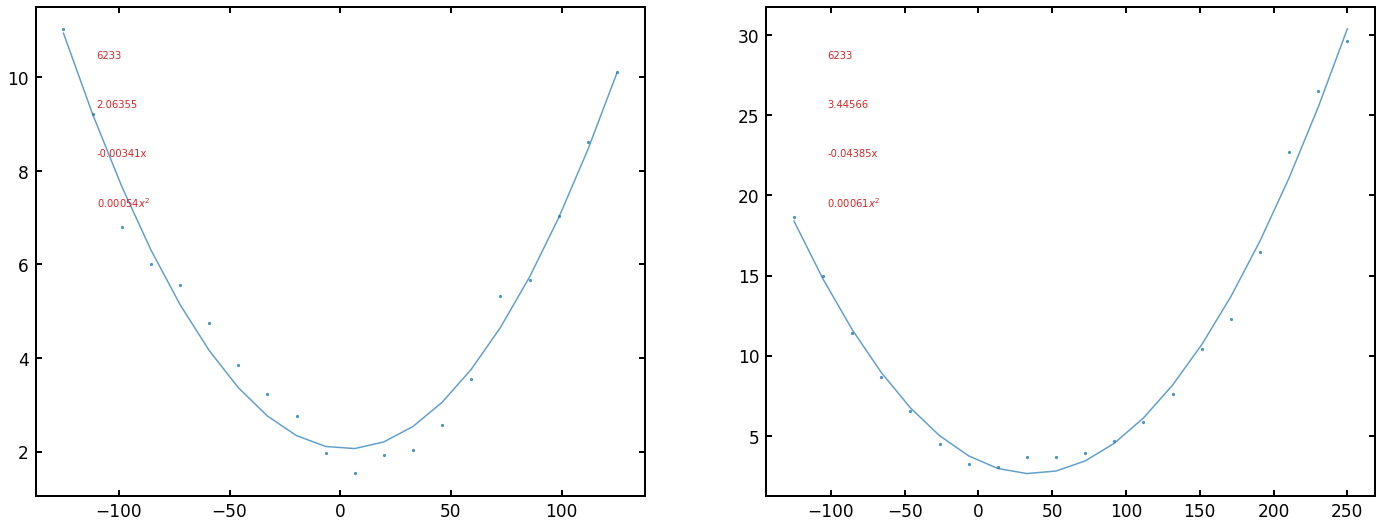

In [44]:

iy,ix = 50,31

# input arcminute  -> degree
delta_ra = 6
delta_dec = delta_ra
# grid nx, ny (even number)
nx = 120
ny = nx
# arcmin, separation angle for shear estimation
radius = 7

# arcmin, smooth scale in the weight
smooth_len = 2


ra_bin = numpy.linspace(fore_ra[igal]-delta_ra, fore_ra[igal]+delta_ra, nx+1)
dec_bin = numpy.linspace(fore_dec[igal]-delta_dec, fore_dec[igal]+delta_dec, ny+1)



grid_ra = (ra_bin[ix] + ra_bin[ix + 1]) / 2
grid_dec = (dec_bin[iy] + dec_bin[iy + 1]) / 2
grid_center = SkyCoord(ra=grid_ra*astro_unit.arcmin, dec=grid_dec*astro_unit.arcmin, frame='fk5')

# background galaxy position
galaxy_pos = SkyCoord(ra=ra * astro_unit.arcmin, dec=dec * astro_unit.arcmin, frame='fk5')
sep_angle = grid_center.separation(galaxy_pos).arcmin

idx_sub = sep_angle <= radius

source_num = idx_sub.sum()

weight = numpy.exp(-sep_angle[idx_sub]**2/2/smooth_len ** 2) * 40

sigma_crit_ = sigma_crit[idx_sub]
mg_t_ = mg_t[idx_sub]*weight
mg_x_ = mg_x[idx_sub]*weight
mn_ = mn[idx_sub]*weight
mu_ = mu[idx_sub]*weight
mnu1 = mn_ + mu_
mnu2 = mn_ - mu_

img = Image_Plot(fig_x=12 , fig_y=9.6)
img.create_subfig(1, 2)
        
tan_g, tan_g_sig = fq.fmin_g_new(g=mg_t_*sigma_crit_, nu=mnu1, bin_num=8, scale=100,
                                 fig_ax=img.axs[0][0], left=-1000,right=1000, fit_num=20, chi_gap=30)[:2]

cross_g, cross_g_sig = fq.fmin_g_new(g=mg_x_*sigma_crit_, nu=mnu2, bin_num=8, scale=100,
                                     fig_ax=img.axs[0][1], left=-1000,right=1000, fit_num=20, chi_gap=30)[:2]
print(tan_g, tan_g_sig, cross_g, cross_g_sig)
img.show_img()
img.close_img()

In [53]:
# set up bin 
bin_num = 16
signal_num = 101
bins = fq.set_bin(mg_t_*sigma_crit_, bin_num, 100)
# show_bins = [-bin_num/2 + i+0.5 for i in range(bin_num)]
show_bins =numpy.array([-bin_num/2 + i for i in range(bin_num)])
print(show_bins)
print(show_bins[:bin_num-1])

# plot PDF of G1(2)


d_g = 100
signal_1 = numpy.linspace(tan_g - d_g,tan_g+d_g,signal_num)
signal_2 = numpy.linspace(cross_g - d_g,cross_g+d_g,signal_num)

chisq_1 = []
chisq_2 = []
with open("/home/hkli/work/temp/PDF/readme.dat","w") as f:
    f.writelines(["""galaxy num = %d
bin_num = %d
signal_num = %d

g_t = %.4f (%.4f)
g_x = %.4f (%.4f)

g_guess = [g-%d ~ g+%d, %d]"""%(source_num, bin_num, signal_num, tan_g, tan_g_sig, cross_g, cross_g_sig, d_g, d_g, signal_num)])
    
for i in range(signal_num):
    
    img = Image_Plot()
    img.create_subfig(1, 2)

    G_h1 = mg_t_*sigma_crit_ - mnu1*signal_1[i]
    
    num1 = numpy.histogram(G_h1, bins)[0]    
    chi = fq.G_bin(mg_t_*sigma_crit_,  mnu1, signal_1[i], bins, 0)
    chisq_1.append(chi)
    
    G_h2 = mg_x_*sigma_crit_ - mnu2*signal_2[i]
    num2 = numpy.histogram(G_h2, bins)[0]
    chi = fq.G_bin(mg_x_*sigma_crit_,  mnu2, signal_2[i], bins, 0)
    chisq_2.append(chi)
    
    img.axs[0][0].bar(numpy.arange(-bin_num/2,bin_num/2),num1,width=1,alpha=0.8,edgecolor='grey', label="%f"%signal_1[i])
    img.axs[0][1].bar(numpy.arange(-bin_num/2,bin_num/2),num2,width=1,alpha=0.8,edgecolor='grey',label="%f"%signal_2[i])
    
#     img.axs[0][0].plot(show_bins, num1,label="%f"%signals[i])
#     img.axs[0][1].plot(show_bins, num2,label="%f"%signals[i])

    img.axs[0][0].legend(loc="lower left")
    img.tick_label(0,0,1,"Bin label")
    img.tick_label(0,0,0,"Number")
    img.axs[0][1].legend(loc="lower left")
    img.tick_label(0,1,1,"Bin label")
    img.tick_label(0,1,0,"Number")
    
    img.save_img("/home/hkli/work/temp/PDF/%d.png"%i)
#     img.show_img()
    img.close_img()
    
img = Image_Plot()
img.create_subfig(1, 1)
img.axs[0][0].plot(signal_1, chisq_1,label="g1")
img.axs[0][0].plot(signal_2, chisq_2, label="g2")
img.axs[0][0].legend()
img.tick_label(0,0,1,"g")
img.tick_label(0,0,0,"$\chi^2$")

img.save_img("/home/hkli/work/temp/PDF/chisq.png")
#     img.show_img()
img.close_img()
print("Done")

[-8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]
[-8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.]
Done
